#### This notebook continues my previous work.
#### If you trained model with https://www.kaggle.com/code/alexeyolkhovikov/segformer-training, you can use this notebook for inference.
#### If you find this notebook useful, please upvote!

In [1]:
!cp -r ../input/pytorch-segmentation-models-lib/ ./
!cp -r ../input/torchmetrics/ ./

!pip config set global.disable-pip-version-check true

!pip install -q ./pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install -q ./pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
!pip install -q ./pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
!pip install -q ./pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl
!pip install -q ./torchmetrics/torchmetrics-0.9.1-py3-none-any.whl

Writing to /root/.config/pip/pip.conf


In [2]:
import pandas as pd
import numpy as np

import os
import json
from tqdm.auto import tqdm
import gc

from skimage import io
from skimage.transform import resize
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation

import pytorch_lightning as pl
from pytorch_lightning import Trainer
import segmentation_models_pytorch as smp
from torchmetrics import Dice
import cv2

In [3]:
TEST_IMG_PATH = "../input/hubmap-organ-segmentation/test_images/"

MODEL_PATH = [
    "../input/unosegformer/Segformer",
]



In [4]:
imaging_measurements = {
    'hpa': {
        'pixel_size': {
            'kidney': 0.4,
            'prostate': 0.4,
            'largeintestine': 0.4,
            'spleen': 0.4,
            'lung': 0.4
        },
        'tissue_thickness': {
            'kidney': 4,
            'prostate': 4,
            'largeintestine': 4,
            'spleen': 4,
            'lung': 4
        }
    },
    'hubmap': {
        'pixel_size': {
            'kidney': 0.5,
            'prostate': 6.263,
            'largeintestine': 0.229,
            'spleen': 0.4945,
            'lung': 0.7562
        },
        'tissue_thickness': {
        'kidney': 10,
            'prostate': 5,
            'largeintestine': 8,
            'spleen': 4,
            'lung': 5
        }
    }
}

In [5]:
def augment_image(image, domain_pixel_size, target_pixel_size, domain_tissue_thickness, target_tissue_thickness, alpha=0.15):
    
    
    # Augment tissue thickness
    tissue_thickness_scale_factor = target_tissue_thickness - domain_tissue_thickness
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float32)
    image_hsv[:, :, 1] *= (1 + (alpha * tissue_thickness_scale_factor))
    image_hsv[:, :, 2] *= (1 - (alpha * tissue_thickness_scale_factor))
    image_hsv = image_hsv.astype(np.uint8)
    image_scaled = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    
    # Standardize luminosity
    #image_scaled = staintools.LuminosityStandardizer.standardize(image_scaled)

    # Augment pixel size
    pixel_size_scale_factor = domain_pixel_size / target_pixel_size
    image_resized = cv2.resize(
        image_scaled,
        dsize=None,
        fx=pixel_size_scale_factor,
        fy=pixel_size_scale_factor,
        interpolation=cv2.INTER_CUBIC
    )
    
    image_resized = cv2.resize(
        image_resized,
        dsize=(
            image.shape[1],
            image.shape[0]
        ),
        interpolation=cv2.INTER_CUBIC
    )
    
    # Standardize luminosity
    
    
    
    
    
    #image_augmented = staintools.LuminosityStandardizer.standardize(image_resized)
    

    returnImage = image_resized
    
    del image_scaled
    del image_resized
    del image

    del image_hsv
    gc.collect()
    
    return returnImage

In [6]:
df_test = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')

In [7]:
#print(df_sample)
organ = df_test[df_test['id'] == 10078]['organ'].values[0]
print(organ)
print(imaging_measurements['hubmap']['pixel_size'][organ])



spleen
0.4945


In [8]:
def mask_to_rle(mask):
    #Rescale image to original size
    size = int(len(mask.flatten())**.5)
    n = Image.fromarray(mask.reshape((size, size))*255.0)
    n = np.array(n).astype(np.float32)
    #Get pixels to flatten
    pixels = n.T.flatten()
    #Round the pixels using the half of the range of pixel value
    pixels = (pixels-min(pixels) > ((max(pixels)-min(pixels))/2)).astype(int)
    pixels = np.nan_to_num(pixels) #incase of zero-div-error
    
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0]
    runs[1::2] -= runs[::2]
    
    return ' '.join(str(x) for x in runs)

In [9]:
class SegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model
        ):
        super(SegmentationModel, self).__init__()
        
        self.model = model
        
        self.criterion = smp.losses.DiceLoss(
            smp.losses.BINARY_MODE,
            from_logits=True,
            log_loss=True
        )

        self.metric = Dice(
            num_classes=1,
            average='none'
        )
        
    def forward(self, image, size):
        outputs = self.model(image)
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=size, 
            mode="bilinear",
            align_corners=False
        )
        
        return upsampled_logits
        

    def training_step(self, batch, batch_idx):
        image, mask = batch[0], batch[1]
        outputs = self.model(pixel_values=image, labels=mask.long())
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=mask.shape[-2:], 
            mode="bilinear",
            align_corners=False
        )
        
        loss = outputs.loss
        
        return {'loss': loss, 'logits_mask': upsampled_logits, 'mask': mask}
    
    def training_epoch_end(self, outputs):
        loss = [item['loss'].item() for item in outputs]
        logits_mask = torch.cat([item['logits_mask'] for item in outputs]).sigmoid()
        mask = torch.cat([item['mask'] for item in outputs])
        
        pred_mask = logits_mask.argmax(dim=1).float()
        
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        log_parameters = {
            "loss_train": np.mean(loss),
            "per_image_iou_train": per_image_iou,
            "dataset_iou_train": dataset_iou,
        }
        
        self.log_dict(log_parameters)
    
    def validation_step(self, batch, batch_idx):
        image, mask = batch[0], batch[1]
        outputs = self.model(pixel_values=image, labels=mask.long())
        
        upsampled_logits = nn.functional.interpolate(
            outputs.logits,
            size=mask.shape[-2:], 
            mode="bilinear",
            align_corners=False
        )
        
        loss = outputs.loss
        
        return {'loss': loss, 'logits_mask': upsampled_logits, 'mask': mask}
        
    def validation_epoch_end(self, outputs):
        loss = torch.from_numpy(np.array([item['loss'].item() for item in outputs]))
        logits_mask = torch.cat([item['logits_mask'] for item in outputs]).sigmoid()
        mask = torch.cat([item['mask'] for item in outputs])
        
        pred_mask = logits_mask.argmax(dim=1).float()
        
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        
        log_parameters = {
            "loss_valid": torch.mean(loss),
            "per_image_iou_valid": per_image_iou,
            "dataset_iou_valid": dataset_iou,
        }
        
        self.log_dict(log_parameters)        

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = PeakScheduler(
            optimizer,
            lr_ramp_ep=int(Config.EPOCHS * 0.25), 
            lr_decay=0.95,
            lr_max=1e-03,
            lr_min=1e-06
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "interval": "epoch", "frequency": 1}
        }

In [10]:
models = []

for p in MODEL_PATH:
    net = SegformerForSemanticSegmentation.from_pretrained(p)
    model = SegmentationModel(net)
    model = model.to("cuda")
    models.append(model)
    

In [11]:
IMG_SIZE = 512

class CustomDatasetTest(Dataset):
    def __init__(
        self, 
        paths: str = None,
        img_size: int = None
        ):
        
        
        
        self.paths = paths
        mean=[196.869, 190.186, 194.802],
        std=[63.01, 66.765, 65.745],
        self.transform = A.Compose([
            A.Resize(img_size, img_size),
            #A.Normalize(mean=mean, std=std, max_pixel_value=1),
            A.Normalize(),
        ])

        self.to_tensor = ToTensorV2()
        self.img_size = img_size
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(
        self, 
        idx: int = None
    ):
        img = np.asarray(Image.open(self.paths[idx]))
        temp = self.paths[idx]
        print(temp)
        img_number = int(temp.split("/")[-1].split(".")[0])
        #img_number = 1000
        
        organ = df_test[df_test['id'] == img_number]['organ'].values[0]


        
        H, W = img.shape[:2]
        
#         img = augment_image(
#             image=img,
#             domain_pixel_size= imaging_measurements['hpa']['pixel_size'][organ],
#             target_pixel_size=imaging_measurements['hubmap']['pixel_size'][organ],
#             domain_tissue_thickness=imaging_measurements['hpa']['tissue_thickness'][organ],
#             target_tissue_thickness=imaging_measurements['hubmap']['tissue_thickness'][organ]
#         )
        
        transformed = self.transform(image=img)
        
        return {
            'image': self.to_tensor(image=transformed['image'].copy())['image'],
#             'image_small': self.to_tensor(image=A.Normalize()(image=A.Resize(512, 512)(image=img)['image'])['image'])['image'],
#             'image_big': self.to_tensor(image=A.Normalize()(image=A.Resize(1024, 1024)(image=img)['image'])['image'])['image'],
#             'image_blurred': self.to_tensor(image=A.Blur(p=1.)(image=transformed['image'].copy())['image'])['image'],
#             'image_jittered': self.to_tensor(image=A.ColorJitter(p=1.)(image=transformed['image'].copy())['image'])['image'],
            'image_num': self.paths[idx].split("/")[-1].split(".")[0],
            'initial_size': (H, W)
        }

In [12]:
paths = [os.path.join(TEST_IMG_PATH, img) for img in os.listdir(TEST_IMG_PATH)]
dataset_test = CustomDatasetTest(paths, IMG_SIZE)
dataloader_test = DataLoader(dataset_test, batch_size=1, drop_last=False)

In [13]:
def rotate(img, k, model):
    logits_rot = model.forward(
        torch.rot90(img, k=k, dims=[2, 3]).to("cuda", dtype=torch.float32),
        #torch.rot90(img, k=k, dims=[2, 3]).to("cpu", dtype=torch.float32),

        size=batch['initial_size']
    ).to("cpu") 
            
    logits_rot = torch.rot90(logits_rot, k=k, dims=[3, 2])
    
    return logits_rot  

def flip_vertical(img, model):
    logits_flipped = model.forward(
        torch.flip(img, dims=[3]).to("cuda", dtype=torch.float32),
        #torch.flip(img, dims=[3]).to("cpu", dtype=torch.float32),
        size=batch['initial_size']
    ).to("cpu") 
    
    logits_flipped = torch.flip(logits_flipped, dims=[3])

    return logits_flipped

def flip_horizontal(img, model):
    logits_flipped = model.forward(
        torch.flip(img, dims=[1, 2]).to("cuda", dtype=torch.float32),
        #torch.flip(img, dims=[1, 2]).to("cpu", dtype=torch.float32),
        size=batch['initial_size']
    ).to("cpu") 
    
    logits_flipped = torch.flip(logits_flipped, dims=[1, 2])

    return logits_flipped

  0%|          | 0/1 [00:00<?, ?it/s]

../input/hubmap-organ-segmentation/test_images/10078.tiff
torch.Size([512, 512, 3])
torch.Size([2023, 2023])


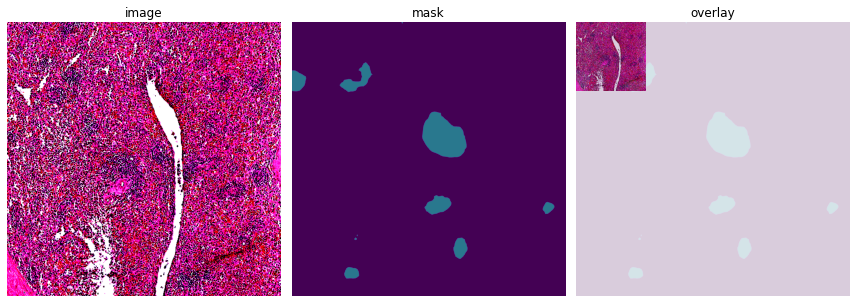

In [14]:
ids = []
rle = []

for _, batch in enumerate(tqdm(dataloader_test)):
    preds = []
    
    with torch.no_grad():
        for model in models:
            model.eval()
            
            img = batch['image']
            
            logits_image = model.forward(
                img.to("cuda", dtype=torch.float32),
                #img.to("cpu", dtype=torch.float32),
                size=batch['initial_size']
            ).to("cpu")
            
#             logits_rot_90 = rotate(img, 1, model)
#             logits_rot_180 = rotate(img, 2, model)
#             logits_rots_270 = rotate(img, 3, model)
            
            logits_flipped_H = flip_horizontal(img, model)
            logits_flipped_V = flip_vertical(img, model)

            #image = logits_image
            preds.extend([logits_image, logits_flipped_H, logits_flipped_V]) #, logits_rot_90, logits_rot_180, logits_rots_270
        
    preds = torch.mean(torch.cat(preds, dim=0), dim=0).unsqueeze(0)
    m = nn.Sigmoid()
    #preds = (preds>0)#.astype(np.uint8)
    
    pr_masks = preds.sigmoid().argmax(1)
    #pr_masks = m(preds).argmax(1)
    
    #pr_masks = pr_masks>2.0
    
    
    
        
    ids.append(batch['image_num'][0])
    rle.append(mask_to_rle(pr_masks.numpy()))
    
    want = pr_masks.squeeze()
    
    
#     original = cv2.resize(batch['image'], dsize=
#             want.shape[-2:]
#         ,
#         interpolation=cv2.INTER_CUBIC)
    
    
    original = np.transpose(batch['image'].squeeze(),(2,1, 0))
    print(original.size())
    print(want.size())
    
    
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 7))
    plt.subplot(1, 3, 1); plt.imshow(original); plt.axis('OFF'); plt.title('image')
    plt.subplot(1, 3, 2); plt.imshow(want*255); plt.axis('OFF'); plt.title('mask')
    plt.subplot(1, 3, 3); plt.imshow(original); plt.imshow(want*255, alpha=0.2); plt.axis('OFF'); plt.title('overlay')
    plt.tight_layout()
    plt.show()

In [15]:
submission = {
    "id": ids,
    "rle": rle
}

In [16]:
submission = pd.DataFrame.from_dict(submission)
submission.to_csv("submission.csv", index=False)

In [17]:
submission

,id,rle
0,10078,1642676 8 1644699 9 1646722 9
